In [1]:
#from __future__ import print_function
%matplotlib inline
from options import Options
from lib.data import load_data
from lib.model import Ganomaly
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

from collections import OrderedDict
import glob,os
import shutil
import time
import numpy as np
from tqdm import tqdm

from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils

from lib.networks import NetG, NetD, weights_init
from lib.visualizer import Visualizer
from lib.loss import l2_loss
from lib.evaluate import evaluate

from astropy.table import QTable
import astropy.units as u
import seaborn as sns
from scipy import stats

import pandas as pd

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
#plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
t_nihao=QTable.read('nihao_stats_rt_1016.csv')
#t_nihao

In [4]:
t_SDSS=QTable.read('t_SDSS.ecsv')
#t_SDSS

In [5]:
fontsize=15

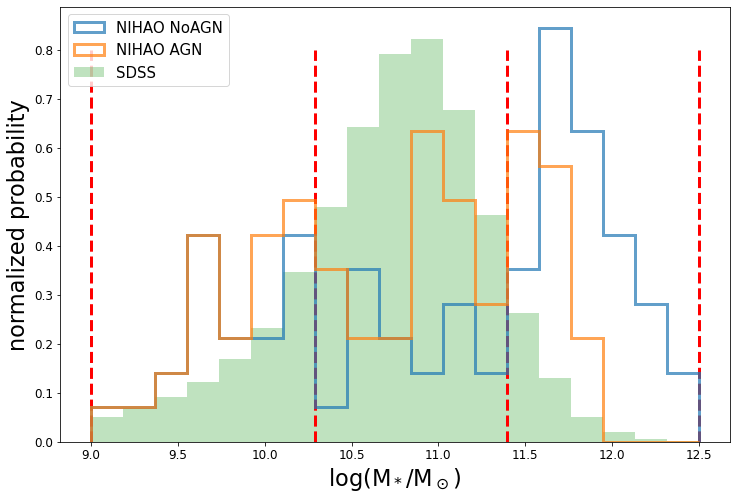

In [6]:
plt.figure(figsize=(12,8))
bins=np.linspace(9,12.5,20)
plt.hist(np.log10(t_nihao['h.star.mass'].value),bins=bins,label='NIHAO NoAGN',density=1,alpha=0.7,histtype='step',lw=3)
plt.hist(np.log10(t_nihao['h.star.mass_bh'].value),bins=bins,label='NIHAO AGN',density=1,alpha=0.7,histtype='step',lw=3)
plt.hist(np.log10(t_SDSS['m']),bins=bins,label='SDSS',density=1,alpha=0.3,lw=3)
plt.vlines((bins[0],bins[7],bins[13],bins[-1]),0,0.8,ls='--',color='r',lw=3)
plt.legend(loc=('upper left'),fontsize=fontsize)
plt.xlabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)
plt.ylabel('normalized probability',fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

In [7]:
bins[0],bins[7],bins[13],bins[-1]

(9.0, 10.289473684210526, 11.394736842105264, 12.5)

In [2]:
# plot=[0,1,2,3]=[no plot,plot all, plot particular scores, plot every 1500]
def visualize_list(imagelist,folder='data/SDSS/test/0.normal/',prefix='',suffix='',plot=0,plotname='',plotfeq=1500):
    imagelist.sort()
    
    # prepare dictories
    try:
        os.makedirs('data/SDSS_test/test/1.abnormal')
        # to make sure the stupid dataloader runs. -- I did not wrtie the dataloader myself.
        os.makedirs('data/SDSS_test/train/0.normal')
        shutil.copy(folder+imagelist[0],'data/SDSS_test/train/0.normal/dummy.png')  
    except:
        pass
    
    # remove old images
    try:
        directory = 'data/SDSS_test/test/1.abnormal/'
        for f in os.listdir(directory):
            os.remove(os.path.join(directory, f))
    except:
        pass
    
    # copy new images in
    for name in imagelist:
        shutil.copy(folder+prefix+str(name)+suffix,'data/SDSS_test/test/1.abnormal/'+prefix+str(name)+suffix)
        
        
    class Args:
        dataset='SDSS_test'
        dataroot=''
        batchsize=1   #batch size
        workers=8
        droplast=True
        isize=64      #input image size.
        nc=3          #input image channels
        nz=128        #size of the latent z vector
        ngf=64
        ndf=64
        extralayers=0 #Number of extra layers on gen and disc
        device='gpu'
        gpu_ids='0'
        ngpu=1
        name='output'
        model='ganomaly'
        display_server="http://localhost"
        display_port=8097
        display_id=0
        display=True   #Use visdom
        outf='./output'
        manualseed=-1   #manual seed
        abnormal_class='car'
        proportion=0.1  #Proportion of anomalies in test set
        metric='roc'    #Evaluation metric.')


        print_freq=100  #frequency of showing training results on console
        save_image_freq=100, #frequency of saving real and fake images
    
    
        save_test_images=False #Save test images for demo
        
    
    
        load_weights=True     #Load the pretrained weights
        resume=''             #path to checkpoints (to continue training
        phase='train'         #train, val, test
        iter=0                #Start from iteration
        niter=15              #number of epochs to train for
        beta1=0.5             #momentum term of adam
        lr=0.0002             #initial learning rate for adam
        w_adv=1               #Adversarial loss weight
        w_con=50              #Reconstruction loss weight
        w_enc=1               #Encoder loss weight
        isTrain = False  #True
        opt = None
    
    opt = Args()
    dataloader = load_data(opt)
    model = Ganomaly(opt, dataloader)
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    %matplotlib inline
    #plt.rcParams["savefig.bbox"] = 'tight'
    plt.rcParams.update({'figure.max_open_warning': 0})
    
    def show(imgs,score,name,plotname):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        #fix.suptitle(name+' $\mathcal{A$ = '+str(score),y=0.77)
        fix.suptitle(plotname+' $\mathcal{A}$ = '+str(score),y=0.77)
        for i, img in enumerate(imgs):
            img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    
    
    
    with torch.no_grad():
        # Load the weights of netg and netd.
        if model.opt.load_weights:
            path = "./output/ganomaly/SDSS/train/weights/netG_43.pth"
            pretrained_dict = torch.load(path)['state_dict']

            try:
                model.netg.load_state_dict(pretrained_dict)
            except IOError:
                raise IOError("netG weights not found")
            print('   Loaded weights.')

        model.opt.phase = 'test'
        loss_con=nn.L1Loss(reduction='none')
        ascore_array=np.zeros(len(model.dataloader['test']))
        

        for i, data in tqdm(enumerate(model.dataloader['test'], 0),total=len(model.dataloader['test'])):
            model.set_input(data)
            model.fake, latent_i, latent_o = model.netg(model.input)

            error = torch.mean(torch.pow((latent_i-latent_o), 2), dim=1)

            un_ascore = error.reshape(error.size(0)).cpu().detach().numpy()
            # normalize scores
            ascore=(un_ascore-0.0007747652)/(0.93256927-0.0007747652)
            #ascore=(un_ascore-unnormalized_score.min())/(unnormalized_score.max()-unnormalized_score.min())
            ascore_array[i]=ascore
            
            if plot==1:
                real, fake, _ = model.get_current_images()
                loss_img=loss_con(model.fake,model.input).data
                grid=make_grid([real[0],fake[0],loss_img[0]],normalize=True)
                show(grid,ascore,imagelist[i],plotname)
            
            if plot==2:
                #if (ascore>0.05)&(ascore<0.1):
                if (ascore>0.5):
                    real, fake, _ = model.get_current_images()
                    loss_img=loss_con(model.fake,model.input).data
                    grid=make_grid([real[0],fake[0],loss_img[0]],normalize=True)
                    show(grid,ascore,imagelist[i],plotname)
                    
            if plot==3:
                if (i%plotfeq==0):
                    real, fake, _ = model.get_current_images()
                    loss_img=loss_con(model.fake,model.input).data
                    grid=make_grid([real[0],fake[0],loss_img[0]],normalize=True)
                    show(grid,ascore,imagelist[i],plotname)
            
        return ascore_array

In [9]:
# mass bin boundaries
bins[0],bins[7],bins[13],bins[-1]

(9.0, 10.289473684210526, 11.394736842105264, 12.5)

In [10]:
SDSS_low=t_SDSS[(np.log10(t_SDSS['m'])>=bins[0])&(np.log10(t_SDSS['m'])<bins[7])]
SDSS_mid=t_SDSS[(np.log10(t_SDSS['m'])>=bins[7])&(np.log10(t_SDSS['m'])<bins[13])]
SDSS_high=t_SDSS[(np.log10(t_SDSS['m'])>=bins[13])&(np.log10(t_SDSS['m'])<bins[-1])]

In [11]:
NoAGN_low=t_nihao[(np.log10(t_nihao['h.star.mass'].value)>=bins[0])&(np.log10(t_nihao['h.star.mass'].value)<bins[7])]
NoAGN_mid=t_nihao[(np.log10(t_nihao['h.star.mass'].value)>=bins[7])&(np.log10(t_nihao['h.star.mass'].value)<bins[13])]
NoAGN_high=t_nihao[(np.log10(t_nihao['h.star.mass'].value)>=bins[13])&(np.log10(t_nihao['h.star.mass'].value)<bins[-1])]

AGN_low=t_nihao[(np.log10(t_nihao['h.star.mass_bh'].value)>=bins[0])&(np.log10(t_nihao['h.star.mass_bh'].value)<bins[7])]
AGN_mid=t_nihao[(np.log10(t_nihao['h.star.mass_bh'].value)>=bins[7])&(np.log10(t_nihao['h.star.mass_bh'].value)<bins[13])]
AGN_high=t_nihao[(np.log10(t_nihao['h.star.mass_bh'].value)>=bins[13])&(np.log10(t_nihao['h.star.mass_bh'].value)<bins[-1])]

Setting up a new session...
Traceback (most recent call last):
  File "/home/zehao/anaconda3/lib/python3.8/site-packages/urllib3/connection.py", line 159, in _new_conn
    conn = connection.create_connection(
  File "/home/zehao/anaconda3/lib/python3.8/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/home/zehao/anaconda3/lib/python3.8/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zehao/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/home/zehao/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 392, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/zehao/anaconda3/lib/python3.8/htt

Exception in user code:
------------------------------------------------------------
   Loaded weights.


100%|██████████| 12793/12793 [01:48<00:00, 117.54it/s]


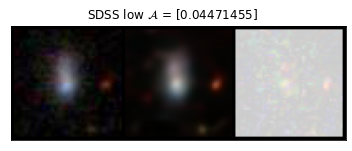

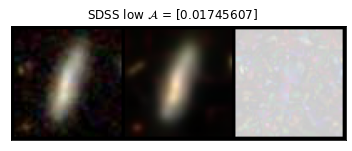

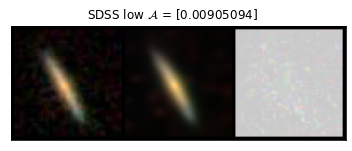

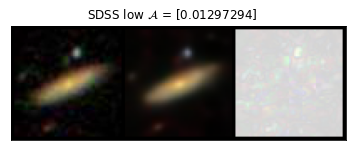

In [12]:
_=visualize_list(SDSS_low['name'],folder='data/SDSS/test/0.normal/',plot=3,suffix='.png',plotname='SDSS low',plotfeq=len(SDSS_low)//3)
# plotting every [plotfeq] images

Setting up a new session...


   Loaded weights.


100%|██████████| 45976/45976 [06:29<00:00, 118.11it/s]


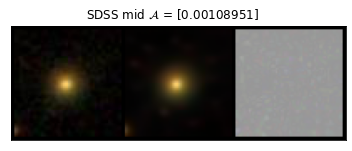

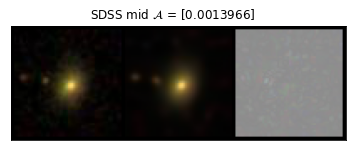

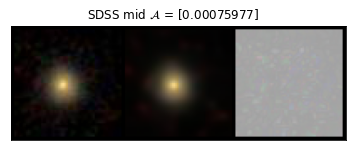

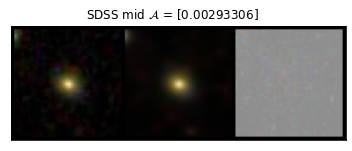

In [13]:
_=visualize_list(SDSS_mid['name'],folder='data/SDSS/test/0.normal/',plot=3,suffix='.png',plotname='SDSS mid',plotfeq=len(SDSS_mid)//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 5572/5572 [00:47<00:00, 116.97it/s]


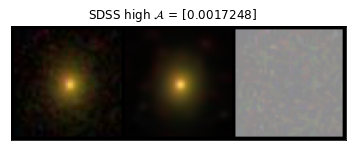

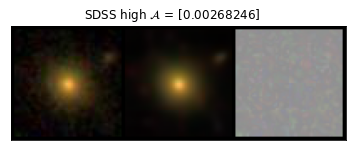

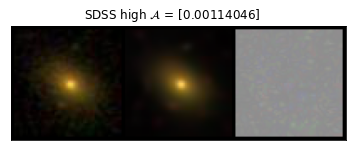

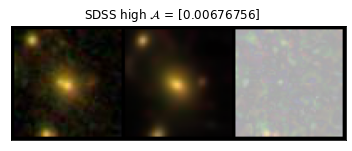

In [14]:
_=visualize_list(SDSS_high['name'],folder='data/SDSS/test/0.normal/',plot=3,suffix='.png',plotname='SDSS high',plotfeq=len(SDSS_high)//3)

In [15]:
def nihao_fn(galaxy,cata='noAGN'):
    imagelist=[]
    for name in galaxy:
        apd=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/'+cata+'_'+name+'*')]       
        imagelist.extend(apd)
    return imagelist

Setting up a new session...


   Loaded weights.


 31%|███       | 135/440 [00:01<00:02, 115.16it/s]

100%|██████████| 440/440 [00:04<00:00, 107.27it/s]


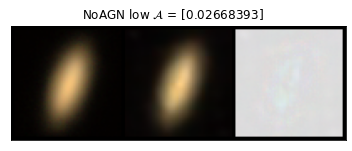

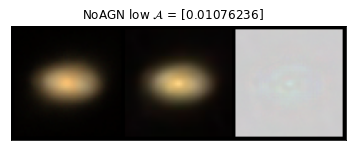

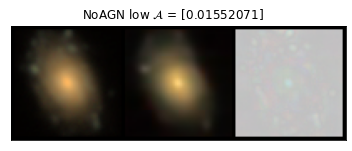

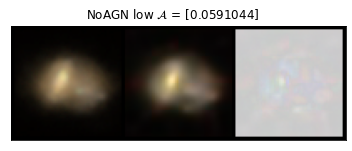

In [21]:
NoAGN_low_score=visualize_list(nihao_fn(NoAGN_low['galaxy'],cata='noAGN'),folder='data/mockobs_1012/',plot=3,plotname='NoAGN low',plotfeq=len(NoAGN_low)*20//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 340/340 [00:03<00:00, 108.21it/s]


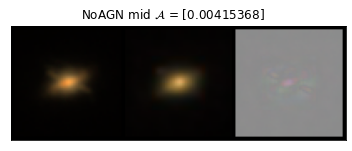

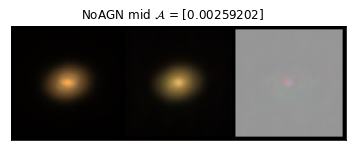

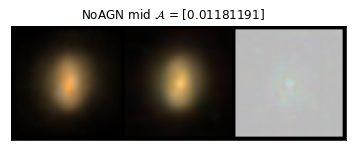

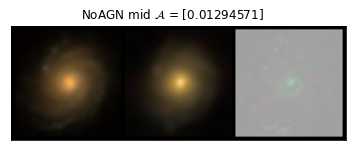

In [22]:
NoAGN_mid_score=visualize_list(nihao_fn(NoAGN_mid['galaxy'],cata='noAGN'),folder='data/mockobs_1012/',plot=3,plotname='NoAGN mid',plotfeq=len(NoAGN_mid)*20//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 760/760 [00:06<00:00, 113.13it/s]


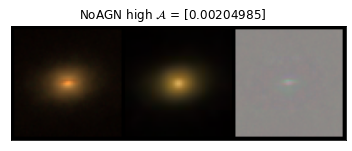

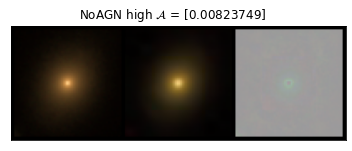

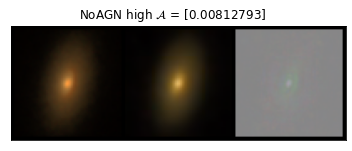

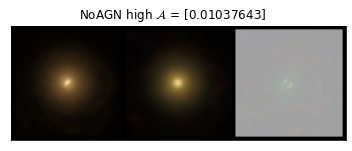

In [26]:
NoAGN_high_score=visualize_list(nihao_fn(NoAGN_high['galaxy'],cata='noAGN'),folder='data/mockobs_1012/',plot=3,plotname='NoAGN high',plotfeq=len(NoAGN_high)*20//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 520/520 [00:04<00:00, 112.25it/s]


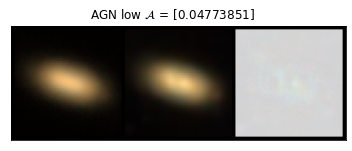

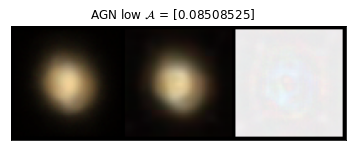

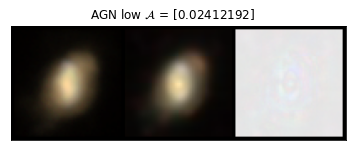

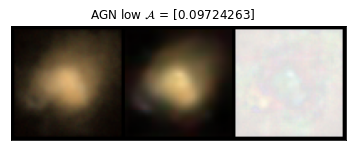

In [27]:
AGN_low_score=visualize_list(nihao_fn(AGN_low['galaxy'],cata='AGN'),folder='data/mockobs_1012/',plot=3,plotname='AGN low',plotfeq=len(AGN_low)*20//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 620/620 [00:05<00:00, 112.91it/s]


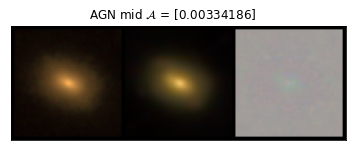

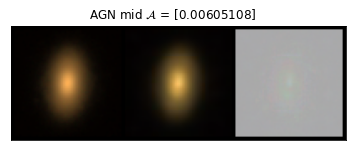

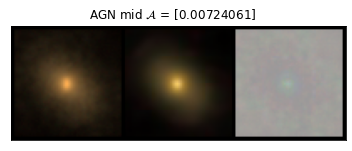

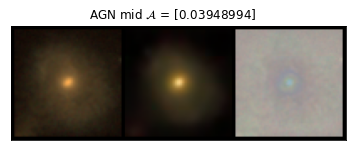

In [28]:
AGN_mid_score=visualize_list(nihao_fn(AGN_mid['galaxy'],cata='AGN'),folder='data/mockobs_1012/',plot=3,plotname='AGN mid',plotfeq=len(AGN_mid)*20//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 400/400 [00:03<00:00, 112.02it/s]


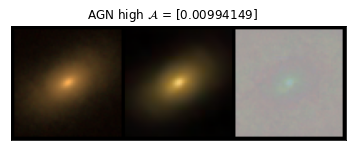

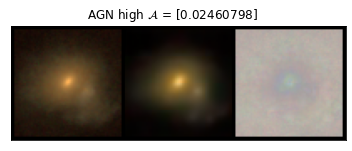

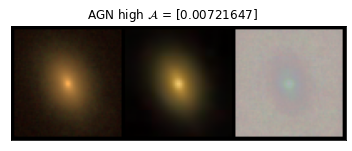

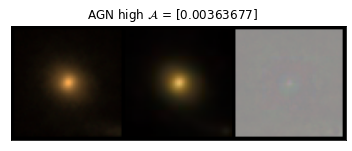

In [29]:
AGN_high_score=visualize_list(nihao_fn(AGN_high['galaxy'],cata='AGN'),folder='data/mockobs_1012/',plot=3,plotname='AGN high',plotfeq=len(AGN_high)*20//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 240/240 [00:02<00:00, 99.34it/s] 


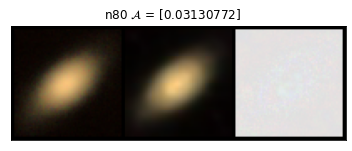

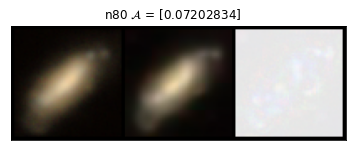

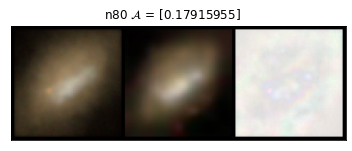

In [30]:
fn=np.array([os.path.basename(x) for x in glob.glob('data/mockobs_1012/n80*')])
fn.sort()
n80_score=visualize_list(fn,folder='data/mockobs_1012/',plot=3,plotname='n80',plotfeq=len(fn)//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 120/120 [00:01<00:00, 97.98it/s] 


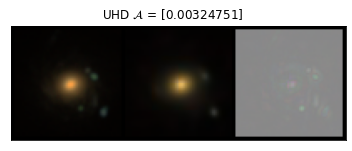

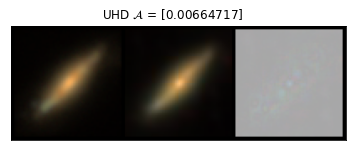

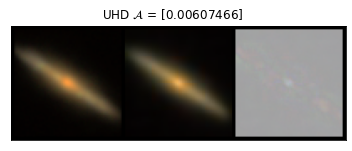

In [31]:
fn=np.array([os.path.basename(x) for x in glob.glob('data/mockobs_1012/UHD*')])
fn.sort()
UHD_score=visualize_list(fn,folder='data/mockobs_1012/',plot=3,plotname='UHD',plotfeq=len(fn)//3)

Setting up a new session...


   Loaded weights.


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


array([1.23040259])

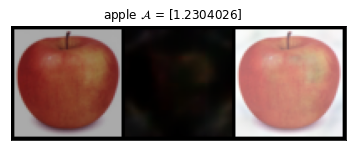

In [32]:
fn=['apple_fun.jpg']
visualize_list(fn,folder='data/fun/',plot=1,plotname='apple')

Setting up a new session...


   Loaded weights.


100%|██████████| 9/9 [00:00<00:00, 18.65it/s]


array([0.99999976, 0.99999976, 0.99999982, 1.        , 0.99999976,
       0.99999976, 0.99999994, 1.00000012, 0.87219787])

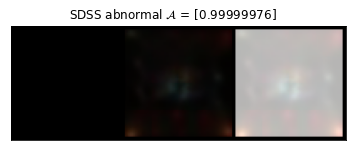

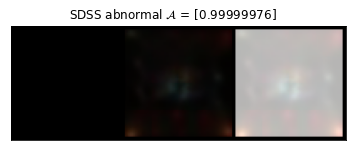

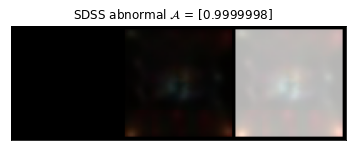

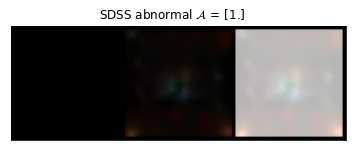

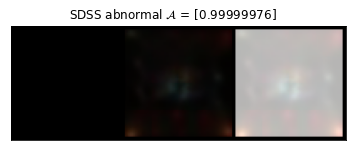

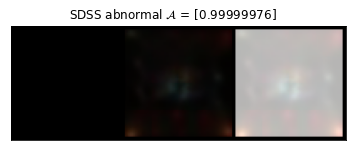

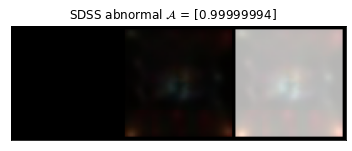

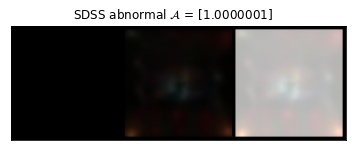

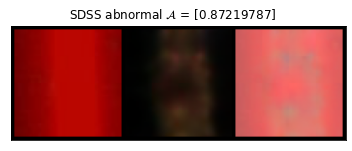

In [26]:
visualize_list(t_SDSS[t_SDSS['score']>0.75]['name'],folder='data/SDSS/test/0.normal/',plot=1,suffix='.png',plotname='SDSS abnormal')

In [33]:
NoAGN_score=np.hstack((NoAGN_low_score,NoAGN_mid_score,NoAGN_high_score))
AGN_score=np.hstack((AGN_low_score,AGN_mid_score,AGN_high_score))

In [34]:
def area(score1,score2,bins=np.linspace(0,0.02,100)):
    hist1,_=np.histogram(score1,density=True,bins=bins)
    hist2,_=np.histogram(score2,density=True,bins=bins)
    
    return np.min([hist1,hist2],axis=0).sum()/hist1.sum()

w/o  bh overlap: 0.6806826928236818
with bh overlap: 0.718052547072319


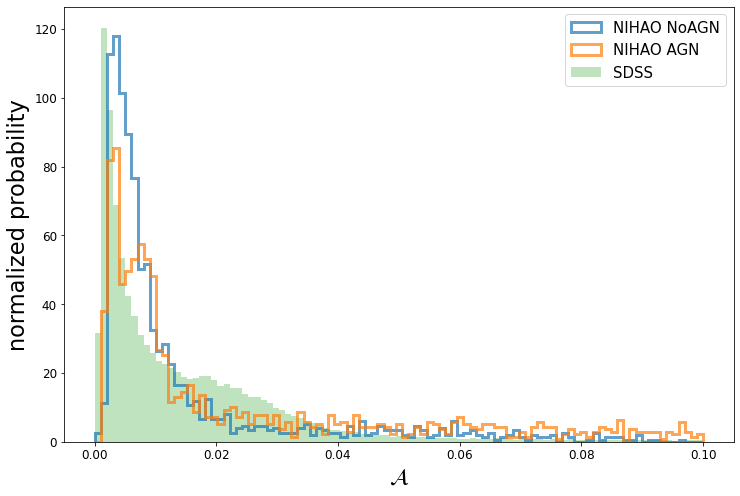

In [48]:
bins=np.linspace(0,0.1,100)
plt.figure(figsize=(12,8))
plt.hist(NoAGN_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO NoAGN')
plt.hist(AGN_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO AGN')
plt.hist(t_SDSS['score'],density=True,bins=bins,lw=3,alpha=0.3,label='SDSS')
plt.legend(fontsize=fontsize)
plt.xlabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.ylabel('normalized probability',fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)

print('w/o  bh overlap:',area(NoAGN_score,t_SDSS['score'],bins=bins))
print('with bh overlap:',area(AGN_score,t_SDSS['score'],bins=bins))

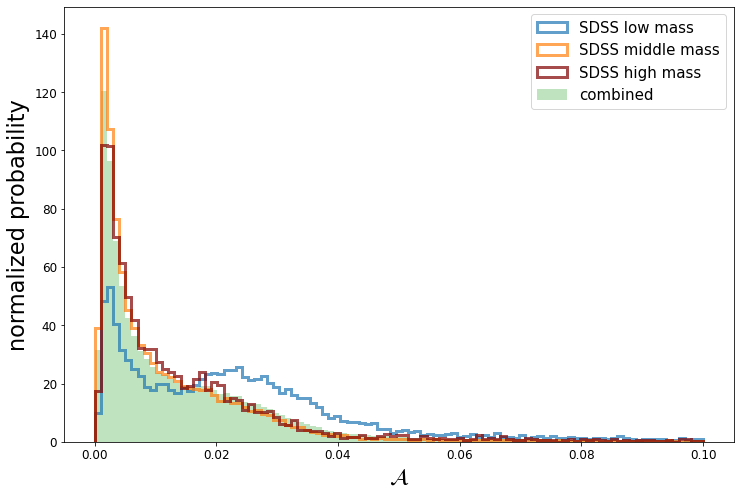

In [46]:
bins=np.linspace(0,0.1,100)
plt.figure(figsize=(12,8))
plt.hist(SDSS_low['score'],density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='SDSS low mass')
plt.hist(SDSS_mid['score'],density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='SDSS middle mass')
plt.hist(SDSS_high['score'],density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='SDSS high mass',color='maroon')
plt.hist(t_SDSS['score'],density=True,bins=bins,lw=3,alpha=0.3,label='combined',color='#2ca02c')
plt.legend(fontsize=fontsize)
plt.xlabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.ylabel('normalized probability',fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

w/o  bh overlap: 0.6821197531929764
with bh overlap: 0.6220338389629491


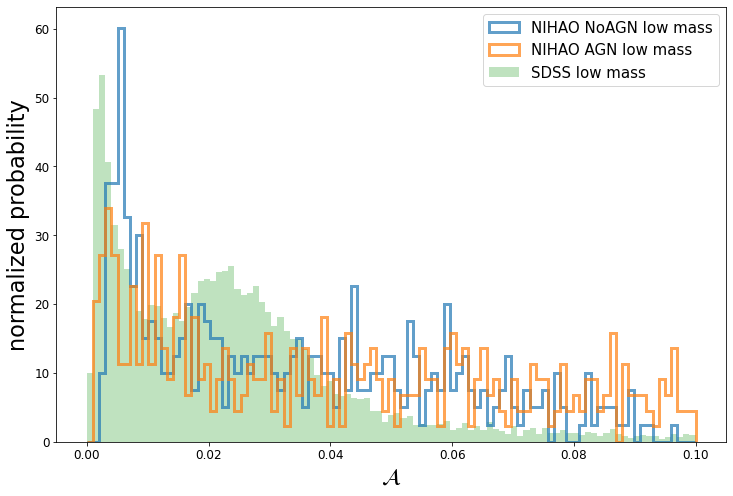

In [37]:
bins=np.linspace(0,0.1,100)
plt.figure(figsize=(12,8))
plt.hist(NoAGN_low_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO NoAGN low mass')
plt.hist(AGN_low_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO AGN low mass')
plt.hist(SDSS_low['score'],density=True,bins=bins,lw=3,alpha=0.3,label='SDSS low mass')
plt.legend(fontsize=fontsize)
plt.xlabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.ylabel('normalized probability',fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

print('w/o  bh overlap:',area(NoAGN_low_score,SDSS_low['score'],bins=bins))
print('with bh overlap:',area(AGN_low_score,SDSS_low['score'],bins=bins))

w/o  bh overlap: 0.5942067815921073
with bh overlap: 0.6621764479548693


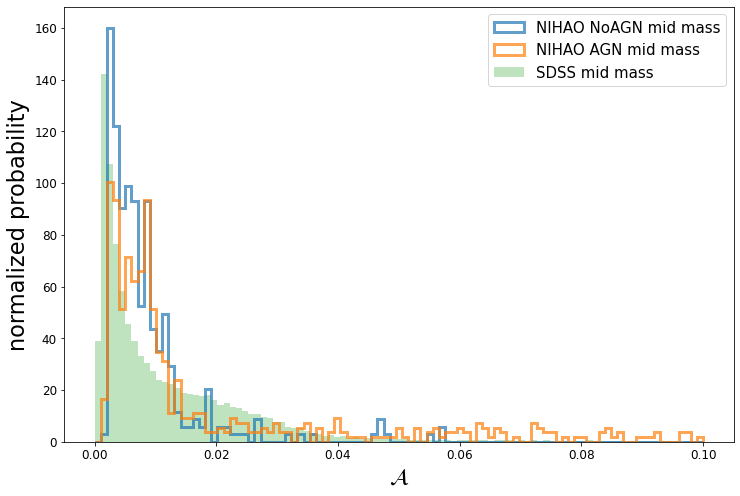

In [38]:
bins=np.linspace(0,0.1,100)
plt.figure(figsize=(12,8))
plt.hist(NoAGN_mid_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO NoAGN mid mass')
plt.hist(AGN_mid_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO AGN mid mass')
plt.hist(SDSS_mid['score'],density=True,bins=bins,lw=3,alpha=0.3,label='SDSS mid mass')
plt.legend(fontsize=fontsize)
plt.xlabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.ylabel('normalized probability',fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

print('w/o  bh overlap:',area(NoAGN_mid_score,SDSS_mid['score'],bins=bins))
print('with bh overlap:',area(AGN_mid_score,SDSS_mid['score'],bins=bins))

w/o  bh overlap: 0.6278283151205146
with bh overlap: 0.735844206103494


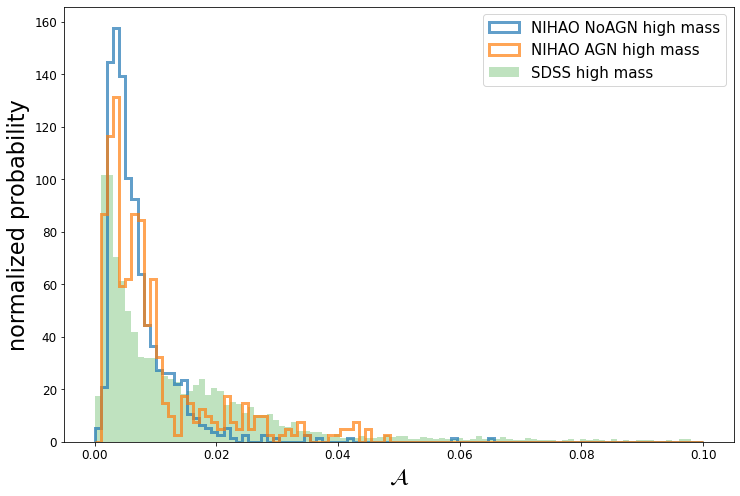

In [39]:
bins=np.linspace(0,0.1,100)
plt.figure(figsize=(12,8))
plt.hist(NoAGN_high_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO NoAGN high mass')
plt.hist(AGN_high_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO AGN high mass')
plt.hist(SDSS_high['score'],density=True,bins=bins,lw=3,alpha=0.3,label='SDSS high mass')
plt.legend(fontsize=fontsize)
plt.xlabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.ylabel('normalized probability',fontsize=fontsize*1.5)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

print('w/o  bh overlap:',area(NoAGN_high_score,SDSS_high['score'],bins=bins))
print('with bh overlap:',area(AGN_high_score,SDSS_high['score'],bins=bins))

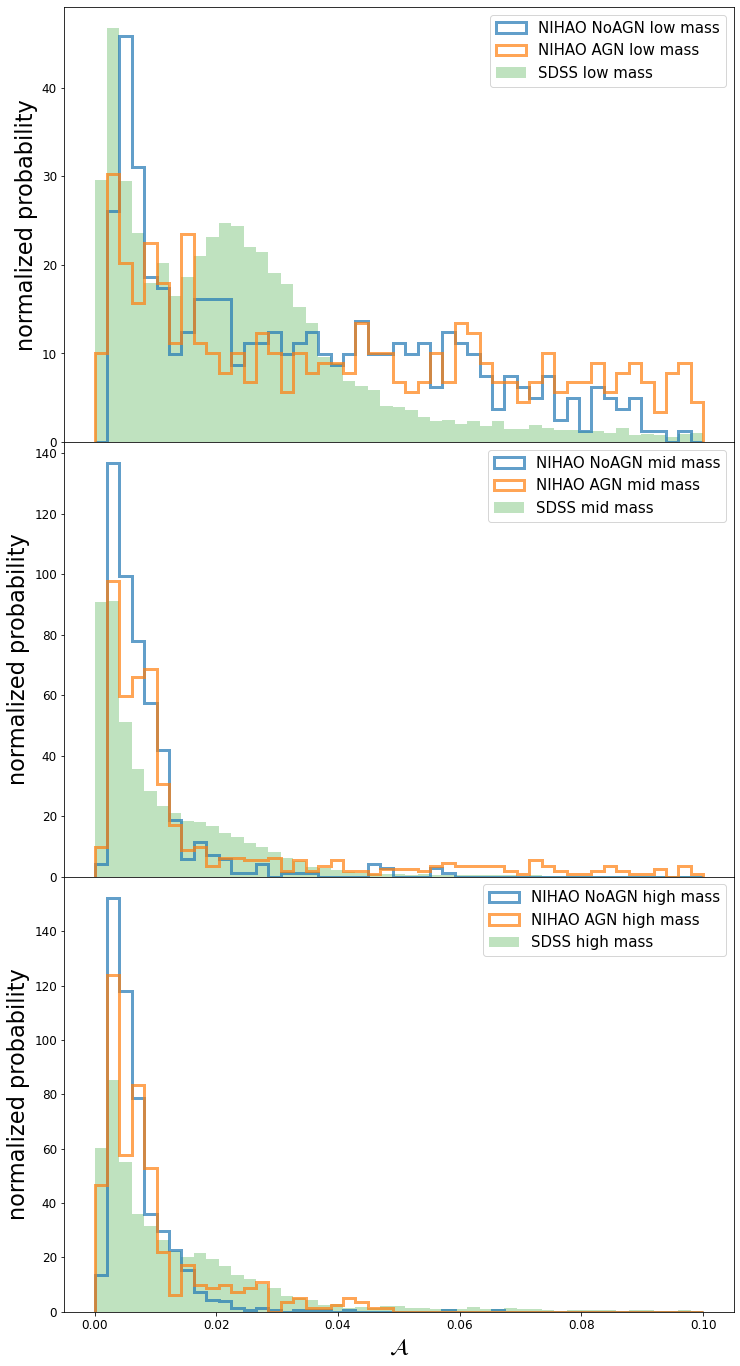

In [44]:
fig, axs = plt.subplots(3, 1, sharex=True,figsize=(12,24))
fig.subplots_adjust(hspace=0)

bins=np.linspace(0,0.1,50)
axs[0].hist(NoAGN_low_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO NoAGN low mass')
axs[0].hist(AGN_low_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO AGN low mass')
axs[0].hist(SDSS_low['score'],density=True,bins=bins,lw=3,alpha=0.3,label='SDSS low mass')
axs[0].set_ylabel('normalized probability',fontsize=fontsize*1.5)
axs[0].tick_params(labelsize=fontsize*0.8)
#axs[0].xaxis.set_tick_params(direction='in',size=fontsize*0.8)
axs[0].legend(fontsize=fontsize)

axs[1].hist(NoAGN_mid_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO NoAGN mid mass')
axs[1].hist(AGN_mid_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO AGN mid mass')
axs[1].hist(SDSS_mid['score'],density=True,bins=bins,lw=3,alpha=0.3,label='SDSS mid mass')
axs[1].set_ylabel('normalized probability',fontsize=fontsize*1.5)
axs[1].tick_params(labelsize=fontsize*0.8)
axs[1].legend(fontsize=fontsize)

axs[2].hist(NoAGN_high_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO NoAGN high mass')
axs[2].hist(AGN_high_score,density=True,bins=bins,histtype='step',lw=3,alpha=0.7,label='NIHAO AGN high mass')
axs[2].hist(SDSS_high['score'],density=True,bins=bins,lw=3,alpha=0.3,label='SDSS high mass')
axs[2].set_xlabel('$\mathcal{A}$',fontsize=fontsize*1.5)
axs[2].set_ylabel('normalized probability',fontsize=fontsize*1.5)
axs[2].tick_params(labelsize=fontsize*0.8)
axs[2].legend(fontsize=fontsize)

In [49]:
n80=t_nihao[t_nihao['n80_mass']!=0]

In [54]:
n80 = n80[(n80['h.star.mass']>=1e9)&(n80['h.star.mass']<=10**12.5)] ##some n80 runs' mother NIHAO1 are not in our mass bin of interest
n80

galaxy,score_mean,score_std,score_mean_bh,score_std_bh,score_mean_UHD,h.star.mass,h.star.mass_bh,SFR100,SFR500,SFR100_bh,SFR500_bh,metals,metals_bh,age,age_bh,b_mag,b_mag_bh,v_mag,v_mag_bh,n80_mass,n80_score_mean,n80_score_std,score_std_UHD
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
g3.71e11,0.04634869082365185,0.01788742589308472,0.06892454582266509,0.03850256449290732,0.0,12661376120.84038,9969259669.596684,1.4770153600000002,1.5036821759999999,0.08390776999999999,0.296888768,0.013416932698757813,0.010208827095979351,5.5502611772320005,6.305252730779588,-3.375630387876314,-2.7743955973033825,-4.186141034179121,-3.608389476333417,1904959947.2746387,0.11750294119119645,0.0315277164391403,0.0
g7.08e11,0.009650855883955955,0.0034707751262196703,0.11495872996747494,0.06057686892788943,0.0467880429700017,31257030023.158638,12204213870.907188,3.64729312,3.42724608,0.005277218124999999,0.001055443625,0.01836776838200638,0.008664307675344107,6.9593897515821626,9.643117754186669,-5.1555162106278285,-4.973209672799149,-6.035799877712113,-5.858199926280112,11202354306.891277,0.08400118425488472,0.032360172499510044,0.045981218918426554
g8.13e11,0.00280179672408849,0.0005174065098557304,0.002754163445206359,0.0010184472199546897,0.0,67190625070.14468,17895798765.01921,3.6315199999999996,3.857368576,0.10237803,0.025119554,0.03295623388656569,0.010623448745045129,8.17615351776133,11.420321693995659,-4.704978324790743,-4.692840477549799,-5.662874769024356,-5.623321036206535,47833543347.01937,0.010371209471486509,0.001646882299872014,0.0
g1.37e11,0.047640555165708066,0.015439954178873163,0.037319389171898365,0.017739205385655547,0.0,2028122297.7647648,2098434850.6420968,0.09498993,0.12311588,0.12625326,0.119867216,0.0053516477127490076,0.005824052847793936,8.333966778678196,8.146280423975933,-3.2504641431255186,-3.2490574517548163,-4.057646288685855,-4.057751974429887,798437699.3131847,0.03588338606059551,0.007792115457916904,0.0
g8.26e11,0.010870388685725629,0.004209242948050251,0.022932566236704588,0.010753101415118324,0.05316352841909975,47384279470.01599,26755577254.790684,2.0285311999999998,2.10215936,0.0021108871875,0.0033774195,0.02300379940227077,0.014480010940324068,8.710515373502316,10.855402388698929,-4.708815973306773,-4.561860918132898,-5.659638133323969,-5.517326875018459,32419445937.16012,0.029934641253203154,0.016606361312135075,0.047507987761383985
g8.06e11,0.013235155493021011,0.003739437797878353,0.019960623513907195,0.015934753288721674,0.0,45025361712.7394,16081591097.932034,13.0868416,10.368698367999999,1.04802936,0.5110405760000001,0.022605230310880797,0.007364614003010652,4.227827021395323,6.769726549103909,-5.792669532444759,-5.426563704788911,-6.583308276799634,-6.2580023906343385,6868908777.470288,0.22530983611941338,0.026004300741326317,0.0
g8.28e11,0.06217916421592236,0.020738807896247956,0.0889254204928875,0.027564034740981885,0.0,18837768782.173225,10947508972.721836,8.04758016,7.571879936,0.8675746400000001,0.47516076799999996,0.00626019816874139,0.004056414890753082,4.487223657148617,6.6491437548106065,-6.464433063915949,-5.8168762278545945,-7.127923006179751,-6.589642701821243,1904841545.8952715,0.09821287579834462,0.018530520302499732,0.0
g2.57e11,0.009382546693086625,0.005677358180825952,0.02647487912327051,0.025544625658642864,0.0,10859397748.405643,8862044036.756472,0.52466652,0.530783872,0.25699356,0.29751910400000003,0.016094631028291673,0.013480524462928169,7.340215573685644,7.646016893936694,-2.776351196939439,-2.786705270561858,-3.6732277982396817,-3.677524044632208,2043485763.551318,0.09784413501620293,0.015103205905519225,0.0
g5.55e11,0.005393112439196557,0.0010859590533418087,0.019691977091133593,0.0105852217652544,0.0,17329741309.91971,15468719409.804394,2.7402287999999997,2.7531312640000003,1.72988112,2.2104962560000003,0.014367433025385375,0.01216334

In [12]:
#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2','#7f7f7f', '#bcbd22', '#17becf']

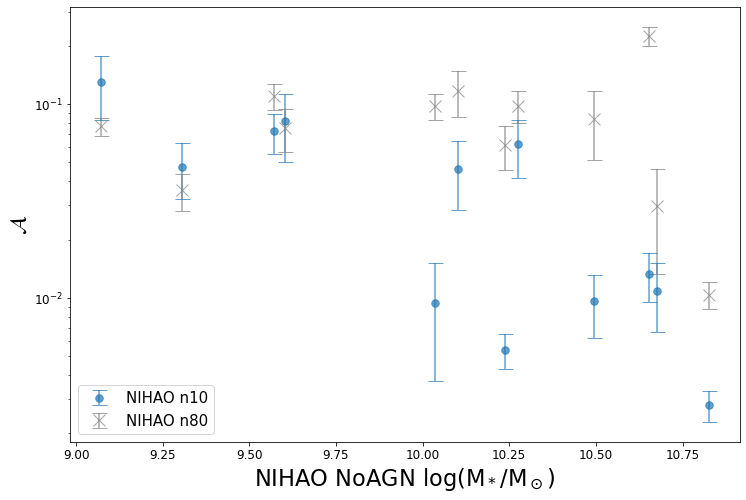

In [55]:
bins=np.linspace(0,0.1,100)
plt.figure(figsize=(12,8))
#plt.errorbar(np.log10(n80['n80_mass']),n80['n80_score_mean'],yerr=n80['n80_score_std'],fmt='.',capsize=3,label='NIHAO n80')
#plt.errorbar(np.log10(n80['h.star.mass'].value),n80['score_mean'],yerr=n80['score_std'],fmt='.',capsize=3,label='NIHAO NoAGN')
#plt.errorbar(np.log10(n80['h.star.mass_bh'].value),n80['score_mean_bh'],yerr=n80['score_std_bh'],fmt='.',capsize=3,label='NIHAO NoAGN')
plt.errorbar(np.log10(n80['h.star.mass'].value),n80['score_mean'],yerr=n80['score_std'],fmt='.',markersize=fontsize,capsize=fontsize/2,label='NIHAO n10',color='#1f77b4',alpha=0.7)
#plt.errorbar(np.log10(n80['h.star.mass'].value),n80['score_mean_bh'],yerr=n80['score_std_bh'],fmt='.',markersize=fontsize,capsize=fontsize/2,label='NIHAO AGN',color='#ff7f0e',alpha=0.7)
plt.errorbar(np.log10(n80['h.star.mass'].value),n80['n80_score_mean'],yerr=n80['n80_score_std'],fmt='x',markersize=fontsize/1.2,capsize=fontsize/2,label='NIHAO n80',color='#7f7f7f',alpha=0.7)
plt.yscale('log')
plt.xlabel('NIHAO NoAGN $\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)
plt.ylabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

In [58]:
UHD=t_nihao[t_nihao['score_mean_UHD']!=0]

In [59]:
UHD

galaxy,score_mean,score_std,score_mean_bh,score_std_bh,score_mean_UHD,h.star.mass,h.star.mass_bh,SFR100,SFR500,SFR100_bh,SFR500_bh,metals,metals_bh,age,age_bh,b_mag,b_mag_bh,v_mag,v_mag_bh,n80_mass,n80_score_mean,n80_score_std,score_std_UHD
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
g7.08e11,0.009650855883955955,0.0034707751262196703,0.11495872996747494,0.06057686892788943,0.0467880429700017,31257030023.158638,12204213870.907188,3.64729312,3.42724608,0.005277218124999999,0.001055443625,0.01836776838200638,0.008664307675344107,6.9593897515821626,9.643117754186669,-5.1555162106278285,-4.973209672799149,-6.035799877712113,-5.858199926280112,11202354306.891277,0.08400118425488472,0.032360172499510044,0.045981218918426554
g2.79e12,0.007306393538601697,0.0030494412469403587,0.08511083321645856,0.043753481717371624,0.006699564983136952,200599193463.98065,89319602580.30887,11.01275392,10.834819072,1.0300848,1.38321408,0.03130709800399194,0.01580204078750926,7.345754475517152,9.669712920259323,-4.825166867803229,-4.158221829087847,-5.769110241979762,-5.102992764616265,0.0,0.0,0.0,0.002345155505600732
g1.12e12,0.0028478602413088082,0.0006843003945678635,0.002944154886063188,0.0003301767333819124,0.002905918669421226,79253146369.30203,27097965684.363148,4.2931568,4.899977216,0.0094989925,0.029552424,0.03312163923062207,0.014840189427265222,7.15013786014087,10.32398594855924,-4.828782665914481,-4.581773667760287,-5.77261222081475,-5.534557492868125,0.0,0.0,0.0,0.0008165952734679594
g7.55e11,0.02625260145869106,0.019260962798532694,0.05826590629294515,0.037252450393865946,0.05982696880819276,31541718857.358063,20901795041.392082,2.90225536,3.0122145280000003,0.5868266799999999,0.36032844799999997,0.01704245965063629,0.012603485320084044,6.515283269811588,8.16670346151351,-5.223558190027628,-4.9686717965421945,-6.093381808074527,-5.865401140755052,0.0,0.0,0.0,0.06350622675090861
g8.26e11,0.010870388685725629,0.004209242948050251,0.022932566236704588,0.010753101415118324,0.05316352841909975,47384279470.01599,26755577254.790684,2.0285311999999998,2.10215936,0.0021108871875,0.0033774195,0.02300379940227077,0.014480010940324068,8.710515373502316,10.855402388698929,-4.708815973306773,-4.561860918132898,-5.659638133323969,-5.517326875018459,32419445937.16012,0.029934641253203154,0.016606361312135075,0.047507987761383985
g6.96e11,0.008598545682616532,0.0013905373007323128,0.22718858271837233,0.058634384492736905,0.008818917511962353,34010346184.53833,13195273055.772394,10.3221344,9.08231168,0.01055443625,0.054460895999999995,0.01519273458380801,0.00558784571301928,3.9585808940983878,6.56977346536826,-6.115857967959088,-5.628065616092286,-6.845587020011388,-6.435871692263513,0.0,0.0,0.0,0.004652066301460379


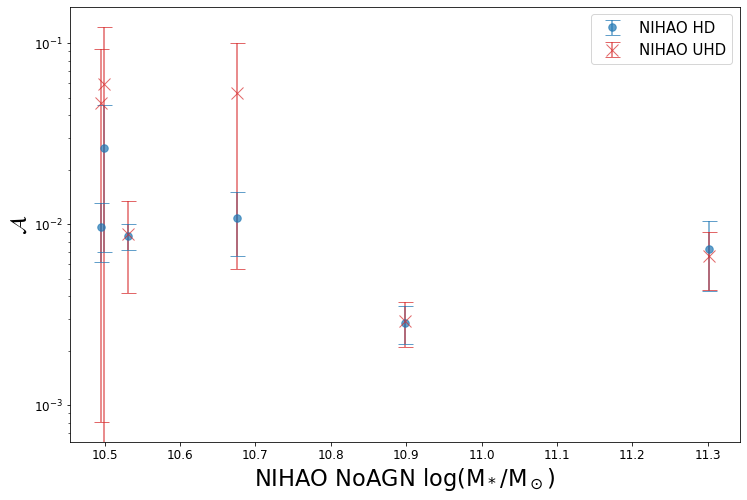

In [63]:
bins=np.linspace(0,0.1,100)
plt.figure(figsize=(12,8))
plt.errorbar(np.log10(UHD['h.star.mass'].value),UHD['score_mean'],yerr=UHD['score_std'],fmt='.',markersize=fontsize,capsize=fontsize/2,label='NIHAO HD',color='#1f77b4',alpha=0.7)
plt.errorbar(np.log10(UHD['h.star.mass'].value),UHD['score_mean_UHD'],yerr=UHD['score_std_UHD'],fmt='x',markersize=fontsize/1.2,capsize=fontsize/2,label='NIHAO UHD',color='#d62728',alpha=0.7)
plt.yscale('log')
plt.xlabel('NIHAO NoAGN $\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)
plt.ylabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

In [64]:
#t_SDSS=QTable.read('t_SDSS.ecsv')
#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2','#7f7f7f', '#bcbd22', '#17becf']

In [65]:
color_scheme={'SDSS':'#2ca02c','NIHAO NoAGN':'#1f77b4','NIHAO AGN':'#ff7f0e','NIHAO n80':'#7f7f7f','NIHAO UHD':'#d62728'}

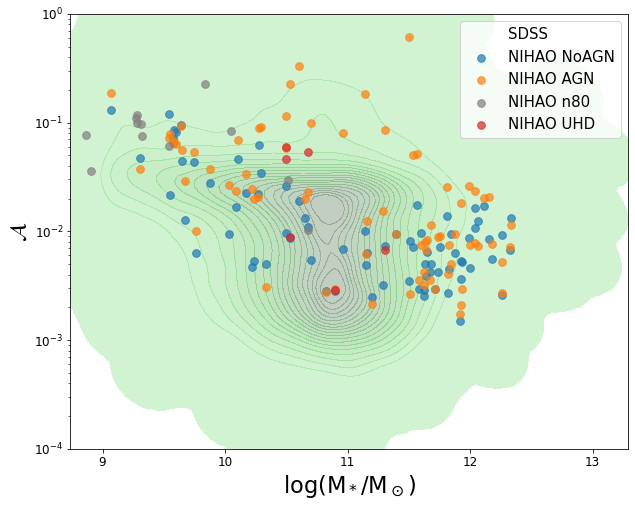

In [66]:
plt.figure(figsize=(10,8))
sns.kdeplot(x=np.log10(t_SDSS['m']),y=t_SDSS['score'],log_scale=(False,True),label='SDSS',fill=True,levels=20,thresh=1e-7,color='#2ca02c',alpha=0.3)
plt.scatter(np.log10(t_nihao['h.star.mass'].value),t_nihao['score_mean'],label='NIHAO NoAGN',s=fontsize*4,c='#1f77b4',alpha=0.7)
plt.scatter(np.log10(t_nihao['h.star.mass'].value),t_nihao['score_mean_bh'],label='NIHAO AGN',s=fontsize*4,c='#ff7f0e',alpha=0.7)
plt.scatter(np.log10(n80['n80_mass']),n80['n80_score_mean'],label='NIHAO n80',s=fontsize*4,c='#7f7f7f',alpha=0.7)
plt.scatter(np.log10(UHD['h.star.mass'].value),UHD['score_mean_UHD'],label='NIHAO UHD',s=fontsize*4,c='#d62728',alpha=0.7)
plt.ylim(1e-4,1)
plt.xlabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)
plt.ylabel('$\mathcal{A}$',fontsize=fontsize*1.5)
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8);

In [72]:
UHD[UHD['n80_mass']!=0]

galaxy,score_mean,score_std,score_mean_bh,score_std_bh,score_mean_UHD,h.star.mass,h.star.mass_bh,SFR100,SFR500,SFR100_bh,SFR500_bh,metals,metals_bh,age,age_bh,b_mag,b_mag_bh,v_mag,v_mag_bh,n80_mass,n80_score_mean,n80_score_std,score_std_UHD
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
g7.08e11,0.009650855883955955,0.0034707751262196703,0.11495872996747494,0.06057686892788943,0.0467880429700017,31257030023.158638,12204213870.907188,3.64729312,3.42724608,0.005277218124999999,0.001055443625,0.01836776838200638,0.008664307675344107,6.9593897515821626,9.643117754186669,-5.1555162106278285,-4.973209672799149,-6.035799877712113,-5.858199926280112,11202354306.891277,0.08400118425488472,0.032360172499510044,0.045981218918426554
g8.26e11,0.010870388685725629,0.004209242948050251,0.022932566236704588,0.010753101415118324,0.05316352841909975,47384279470.01599,26755577254.790684,2.0285311999999998,2.10215936,0.0021108871875,0.0033774195,0.02300379940227077,0.014480010940324068,8.710515373502316,10.855402388698929,-4.708815973306773,-4.561860918132898,-5.659638133323969,-5.517326875018459,32419445937.16012,0.029934641253203154,0.016606361312135075,0.047507987761383985


In [28]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/noAGN_g7.08e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g7.08e11 NIHAO NoAGN')

In [29]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/AGN_g7.08e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g7.08e11 NIHAO AGN')

In [30]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/n80_g7.08e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g7.08e11 NIHAO n80')

In [31]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/UHD_g7.08e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g7.08e11 NIHAO UHD')

In [32]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/noAGN_g8.26e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g8.26e11 NIHAO NoAGN')

In [33]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/AGN_g8.26e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g8.26e11 NIHAO AGN')

In [34]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/n80_g8.26e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g8.26e11 NIHAO n80')

In [35]:
# fn=[os.path.basename(x) for x in glob.glob('data/mockobs_1012/UHD_g8.26e11*')]
# visualize_list(fn,folder='data/mockobs_1012/',plot=1,plotname='g8.26e11 NIHAO UHD')

In [6]:
nik_nihao=QTable.read('NIHAO_AGN_params_with_SFR.csv')
nik_manga=QTable.read('MaNGA_dr17_structural_params_with_chem.csv')

In [7]:
nik_nihao=nik_nihao[0:-11]
nik_nihao

ID,Simulation,log_R10,Mstar_10,V_10,Sigma1,Mgas_10,SFR
str8,str3,float64,float64,float64,float64,float64,float64
g1.05e11,AGN,--,--,--,6.955014573,--,56700000.0
g1.08e11,AGN,0.4229741,8.552460237,1.683270567,7.404557422,8.427813303,38100000.0
g1.12e12,AGN,0.914640132,10.3975959,2.268061085,9.275935374,9.50601322,0.0
g1.37e11,AGN,0.619318796,9.202820498,1.938395829,7.938403217,9.025623775,94200000.0
g1.52e11,AGN,--,--,--,7.023275949,--,9342044.544
g1.57e11,AGN,0.206108972,8.003737843,1.291180397,7.158614723,7.61867583,73900000.0
g1.59e11,AGN,--,--,--,6.906197997,--,12900000.0
g1.64e11,AGN,--,--,--,6.529317112,--,482000000.0
g1.92e12,AGN,0.982266632,10.62833842,2.369100037,9.485449729,9.56600326,98337.31099


In [8]:
nik_nihao['score_mean']=0.
nik_nihao['score_std']=0.
for row in nik_nihao:
    if len(t_nihao[t_nihao['galaxy']==row['ID']])!=0:
        row['score_mean']=t_nihao[t_nihao['galaxy']==row['ID']]['score_mean_bh']
        row['score_std']=t_nihao[t_nihao['galaxy']==row['ID']]['score_std_bh']

In [9]:
nik_nihao=nik_nihao[nik_nihao['score_mean']!=0]

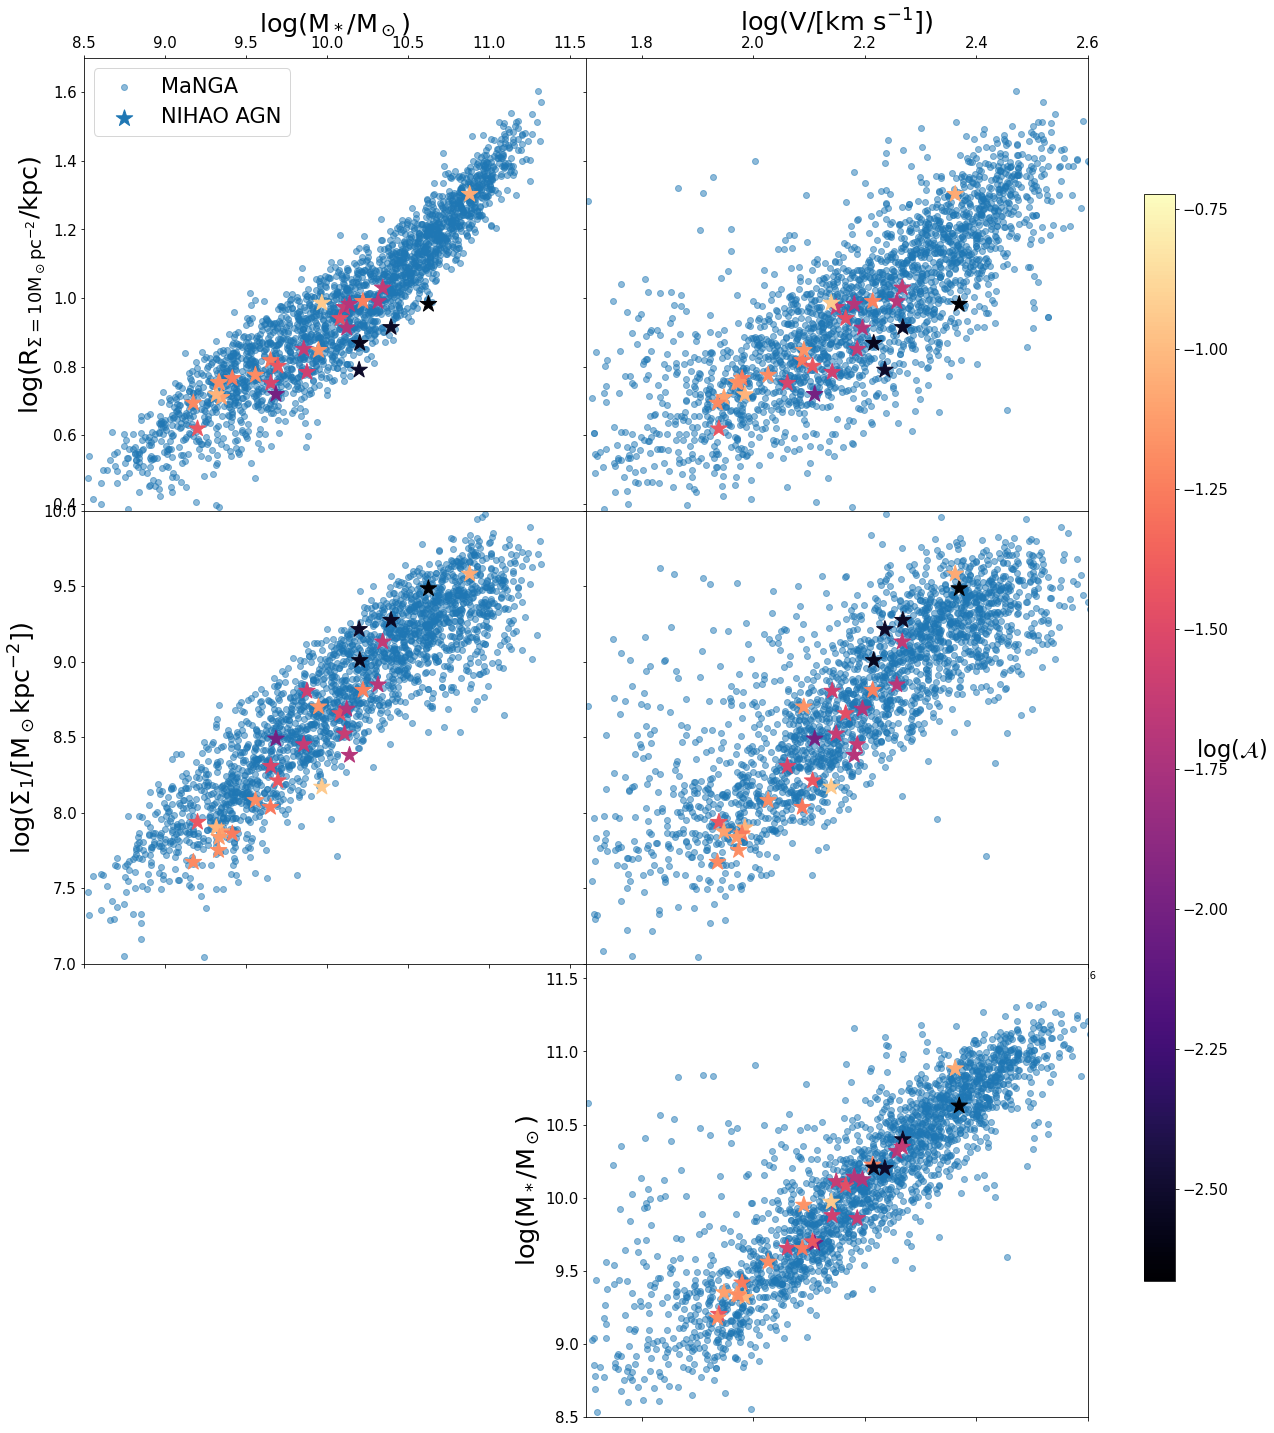

In [13]:
# Start with a square Figure.
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(3, 2,  width_ratios=(1,1), height_ratios=(1,1,1),wspace=0,hspace=0)

ax00=fig.add_subplot(gs[0, 0])
ax00.scatter(nik_manga['Mstar_10'],nik_manga['log_R10'],label='MaNGA',alpha=0.5)
cb=ax00.scatter(nik_nihao['Mstar_10'],nik_nihao['log_R10'],marker='*',s=300,label='NIHAO AGN',c=np.log10(nik_nihao['score_mean']),cmap='magma')
ax00.set_xlim(8.5,11.6)
ax00.set_ylim(0.38,1.7)
ax00.set_xlabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.7)
ax00.xaxis.set_label_position('top') 
ax00.xaxis.tick_top()
ax00.set_ylabel('$\mathrm{log(R_{\Sigma=10 M_\odot pc^{-2}}/kpc)}$',fontsize=fontsize*1.7)
ax00.tick_params(axis='both', labelsize=fontsize)
ax00.legend(fontsize=fontsize*1.4)

ax01=fig.add_subplot(gs[0, 1],sharey=ax00)
ax01.scatter(nik_manga['V_10'],nik_manga['log_R10'],label='MaNGA',alpha=0.5)
ax01.scatter(nik_nihao['V_10'],nik_nihao['log_R10'],marker='*',s=300,label='NIHAO',c=np.log10(nik_nihao['score_mean']),cmap='magma')
ax01.set_xlabel('$\mathrm{log(V/[km\ s^{-1}])}$',fontsize=fontsize*1.7)
ax01.xaxis.set_label_position('top') 
ax01.xaxis.tick_top()
ax01.tick_params(axis='both', labelsize=fontsize)
plt.setp(ax01.get_yticklabels(), visible=False);

ax10=fig.add_subplot(gs[1, 0],sharex=ax00)
ax10.scatter(nik_manga['Mstar_10'],nik_manga['Sigma1'],label='MaNGA',alpha=0.5)
ax10.scatter(nik_nihao['Mstar_10'],nik_nihao['Sigma1'],marker='*',s=300,label='NIHAO',c=np.log10(nik_nihao['score_mean']),cmap='magma')
ax10.set_ylim(7,10)
#ax10.set_xlabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)
ax10.set_ylabel('$\mathrm{log(\Sigma_1/[M_\odot kpc^{-2}])}$',fontsize=fontsize*1.7)
ax10.tick_params(axis='both', labelsize=fontsize)
plt.setp(ax10.get_xticklabels(), visible=False);

ax11=fig.add_subplot(gs[1, 1],sharex=ax01,sharey=ax10)
ax11.scatter(nik_manga['V_10'],nik_manga['Sigma1'],label='MaNGA',alpha=0.5)
ax11.scatter(nik_nihao['V_10'],nik_nihao['Sigma1'],marker='*',s=300,label='NIHAO',c=np.log10(nik_nihao['score_mean']),cmap='magma')
plt.setp(ax11.get_yticklabels(), visible=False);

ax21=fig.add_subplot(gs[2, 1],sharex=ax11)
ax21.scatter(nik_manga['V_10'],nik_manga['Mstar_10'],label='MaNGA',alpha=0.5)
ax21.scatter(nik_nihao['V_10'],nik_nihao['Mstar_10'],marker='*',s=300,label='NIHAO',c=np.log10(nik_nihao['score_mean']),cmap='magma')
ax21.set_xlim(1.7,2.6)
ax21.set_ylim(8.5,11.6)
#ax21.set_xlabel('$\mathrm{log(V/[km\ s^{-1}])}$',fontsize=fontsize*1.5)
ax21.set_ylabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.7)
ax21.tick_params(axis='both', labelsize=fontsize)
plt.setp(ax21.get_xticklabels(), visible=False);

cbar=fig.colorbar(cb,ax=[ax00,ax01,ax10,ax11,ax21],
            fraction=0.05,aspect=35,shrink=0.8)
cbar.set_label(label='$\mathrm{log}(\mathcal{A})$',size=fontsize*1.5,weight='bold',rotation=0)
cbar.ax.tick_params(labelsize=fontsize)




#ax.set_xlabel('$\mathrm{Z\ [Z_{\odot}]}$',fontsize=fontsize*1.5)
#ax.set_ylabel('$\mathcal{A}$',fontsize=fontsize*1.5)
#ax.legend(fontsize=fontsize)
#ax.tick_params(axis='both', labelsize=fontsize*0.8)

Setting up a new session...


   Loaded weights.


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


array([0.0267757])

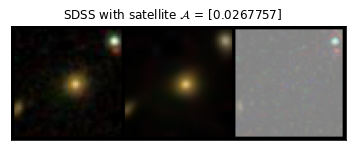

In [94]:
fn=np.array([os.path.basename(x) for x in glob.glob('data/fun/*')])
fn.sort()
visualize_list(fn[:1],folder='data/fun/',plot=1,plotname='SDSS with satellite')

Setting up a new session...


   Loaded weights.


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


array([0.02770448])

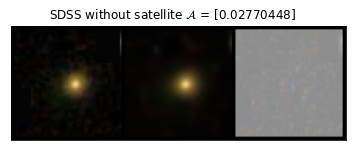

In [95]:
visualize_list(fn[1:2],folder='data/fun/',plot=1,plotname='SDSS without satellite')

In [12]:
#df_SDSS=pd.read_csv('statmorph_SDSS_i.csv')
#df_AGN=pd.read_csv('statmorph_AGN_i.csv')
#df_noAGN=pd.read_csv('statmorph_noAGN_i.csv')

df_SDSS=pd.read_csv('statmorph_SDSS_i.csv')
df_SDSS=df_SDSS[df_SDSS['flag']==0]

df_AGN=pd.read_csv('statmorph_AGN_i.csv')
df_AGN=df_AGN[df_AGN['flag']!=4]
df_AGN=df_AGN[df_AGN['gini']>=0]

df_noAGN=pd.read_csv('statmorph_noAGN_i.csv')
df_noAGN=df_noAGN[df_noAGN['flag']!=4]

In [9]:
# write a function, given x and y, divide x into bins and calculate the median and 16th to 84th percentile range of y in each bin, and then plot the median and percentile range as shaded region
def plot_median_percentile(x,y,nbin=10,*args,**kwargs):
    x=np.array(x)
    y=np.array(y)
    xbin=np.linspace(x.min(),x.max(),nbin+1)
    xbin_center=(xbin[1:]+xbin[:-1])/2
    y_median=np.zeros(nbin)
    y_16th=np.zeros(nbin)
    y_84th=np.zeros(nbin)
    for i in range(nbin):
        y_median[i]=np.median(y[(x>=xbin[i])&(x<xbin[i+1])])
        y_16th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],16)
        y_84th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],84)
    plt.plot(xbin_center,y_median,'o',*args,**kwargs)
    plt.fill_between(xbin_center,y_16th,y_84th,alpha=0.3)

# write a function, given x, y and score, divide x into bins and calculate the median and 16th to 84th percentile range of y in each bin, as well as mean of score in each bin,
# and then plot the median and percentile range of y as shaded region, and color the points according to the mean of score
def plot_median_percentile_color(x,y,score,nbin=10,*args,**kwargs):
    x=np.array(x)
    y=np.array(y)
    score=np.array(score)
    xbin=np.linspace(x.min(),x.max(),nbin+1)
    xbin_center=(xbin[1:]+xbin[:-1])/2
    y_median=np.zeros(nbin)
    y_16th=np.zeros(nbin)
    y_84th=np.zeros(nbin)
    score_mean=np.zeros(nbin)
    for i in range(nbin):
        y_median[i]=np.median(y[(x>=xbin[i])&(x<xbin[i+1])])
        y_16th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],16)
        y_84th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],84)
        score_mean[i]=np.mean(score[(x>=xbin[i])&(x<xbin[i+1])])
        
    #print(xbin_center,y_median,y_16th,y_84th,score_mean)
    plt.scatter(xbin_center,y_median,c=np.log10(score_mean),cmap='magma',s=50,*args,**kwargs)
    plt.fill_between(xbin_center,y_16th,y_84th,alpha=0.3)


# make a function to plot the above three plots, for any statistic
def plot_statistic(statistic):
    plot_median_percentile(np.log10(df_SDSS['m']),df_SDSS[statistic],label='SDSS')
    plot_median_percentile_color(np.log10(df_AGN['m']),df_AGN[statistic],df_AGN['score'],label='AGN',marker='s')
    plot_median_percentile_color(np.log10(df_noAGN['m']),df_noAGN[statistic],df_noAGN['score'],label='noAGN',marker='^')
    plt.colorbar()
    plt.xlabel('log10(mass)')
    plt.ylabel(statistic)
    plt.legend ()

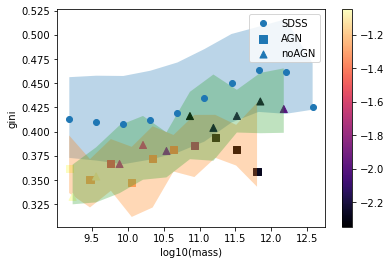

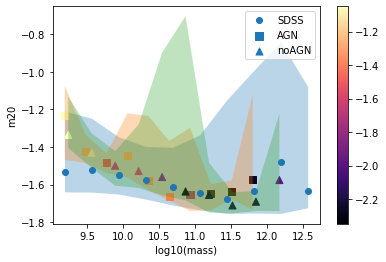

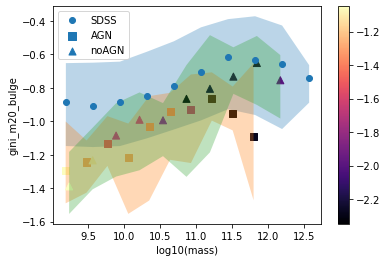

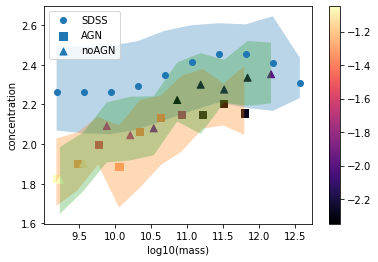

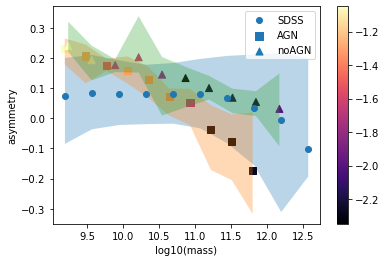

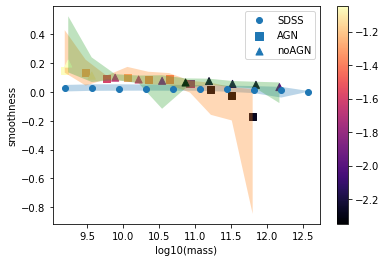

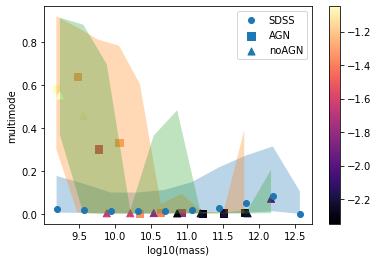

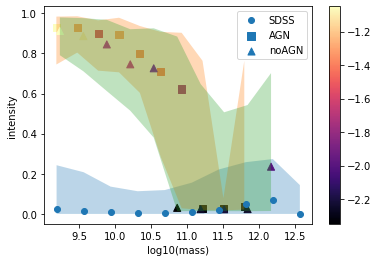

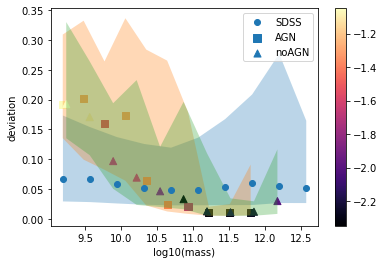

In [10]:
statstics = ['gini','m20','gini_m20_bulge','concentration','asymmetry','smoothness','multimode','intensity', 'deviation']
for statistic in statstics:
    plot_statistic(statistic)
    plt.show()

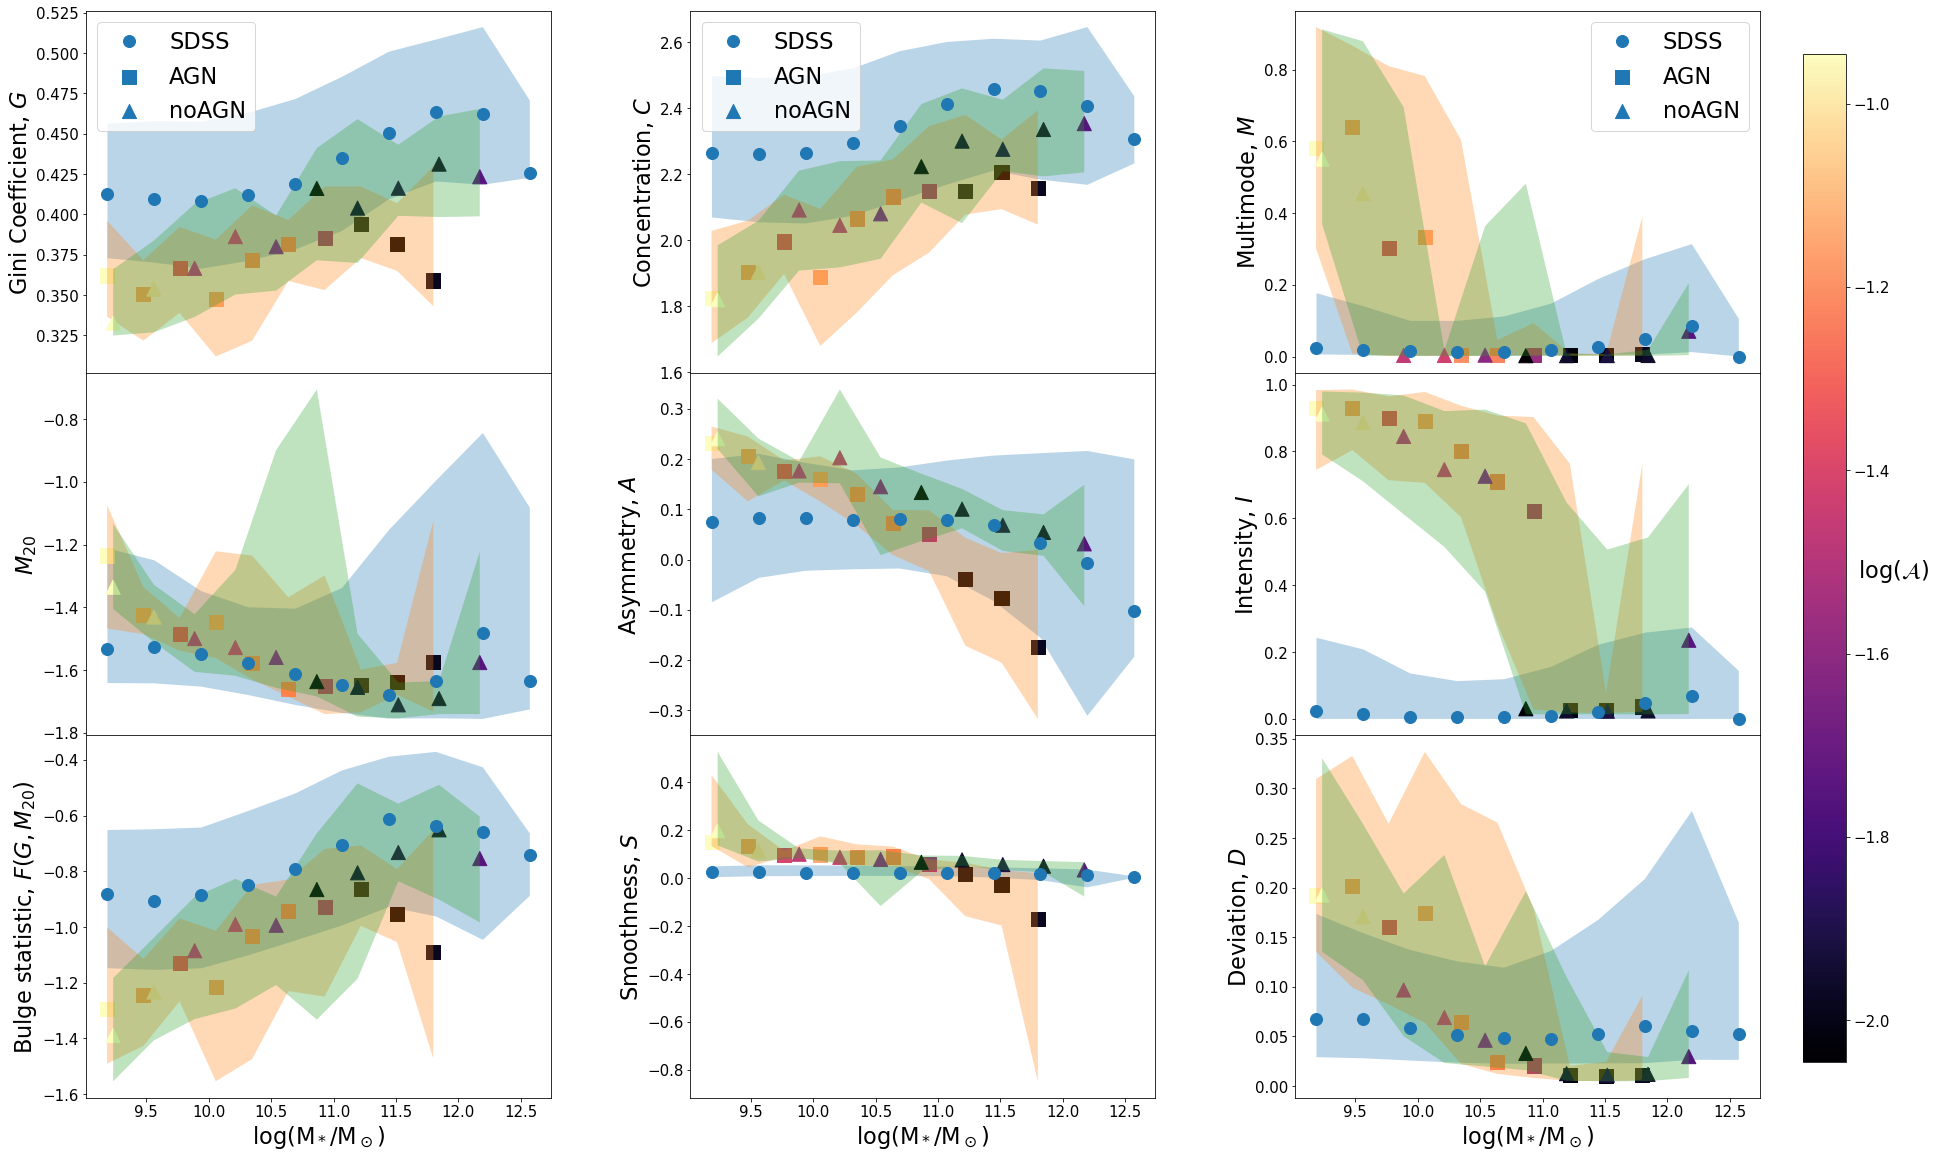

In [77]:
# make a function to plot the above three plots, for any statistic
def plot_median_percentile(x,y,nbin=10,ax=None,*args,**kwargs):
    x=np.array(x)
    y=np.array(y)
    xbin=np.linspace(x.min(),x.max(),nbin+1)
    xbin_center=(xbin[1:]+xbin[:-1])/2
    y_median=np.zeros(nbin)
    y_16th=np.zeros(nbin)
    y_84th=np.zeros(nbin)
    for i in range(nbin):
        y_median[i]=np.median(y[(x>=xbin[i])&(x<xbin[i+1])])
        y_16th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],16)
        y_84th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],84)
    
    ax.plot(xbin_center,y_median,'o',markersize=12,*args,**kwargs)
    ax.fill_between(xbin_center,y_16th,y_84th,alpha=0.3)

def plot_median_percentile_color(x,y,score,nbin=10,ax=None,*args,**kwargs):
    x=np.array(x)
    y=np.array(y)
    score=np.array(score)
    xbin=np.linspace(x.min(),x.max(),nbin+1)
    xbin_center=(xbin[1:]+xbin[:-1])/2
    y_median=np.zeros(nbin)
    y_16th=np.zeros(nbin)
    y_84th=np.zeros(nbin)
    score_mean=np.zeros(nbin)
    for i in range(nbin):
        y_median[i]=np.median(y[(x>=xbin[i])&(x<xbin[i+1])])
        y_16th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],16)
        y_84th[i]=np.percentile(y[(x>=xbin[i])&(x<xbin[i+1])],84)
        score_mean[i]=np.mean(score[(x>=xbin[i])&(x<xbin[i+1])])
        
    #print(xbin_center,y_median,y_16th,y_84th,score_mean)
    ax.scatter(xbin_center,y_median,c=np.log10(score_mean),cmap='magma',s=200,*args,**kwargs)
    ax.fill_between(xbin_center,y_16th,y_84th,alpha=0.3)

# make a function to plot the above three plots, for any statistic
def plot_statistic(statistic, ax,i):
    plot_median_percentile(np.log10(df_SDSS['m']),df_SDSS[statistic],label='SDSS', ax=ax)
    plot_median_percentile_color(np.log10(df_AGN['m']),df_AGN[statistic],df_AGN['score'],label='AGN',marker='s', ax=ax)
    plot_median_percentile_color(np.log10(df_noAGN['m']),df_noAGN[statistic],df_noAGN['score'],label='noAGN',marker='^', ax=ax)
    #plt.colorbar(ax=ax)
    #ax.set_xlabel('$\mathrm{log(M_*/M_\odot)}$')
    ax.set_ylabel(names[i],fontsize=fontsize*1.5)
    #ax.legend()


# create a 3x3 grid of plots, with each column having its own y-axis
fig, axs = plt.subplots(3, 3, figsize=(30, 20), sharex=True, gridspec_kw={'hspace': 0, 'wspace': 0.3})

# loop over each statistic and plot it in the grid
statstics = ['gini','m20','gini_m20_bulge','concentration','asymmetry','smoothness','multimode','intensity', 'deviation']
names = ['Gini Coefficient, $G$', '$M_{20}$', 'Bulge statistic, $F(G,M_{20})$', 
         'Concentration, $C$', 'Asymmetry, $A$', 'Smoothness, $S$', 
         'Multimode, $M$', 'Intensity, $I$', 'Deviation, $D$']
for i, statistic in enumerate(statstics):
    ii,jj=i%3,i//3
    plot_statistic(statistic, axs[ii, jj],i)

# add x-axis label to the bottom row of plots
axs[2, 0].set_xlabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)
axs[2, 1].set_xlabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)
axs[2, 2].set_xlabel('$\mathrm{log(M_*/M_\odot)}$',fontsize=fontsize*1.5)

# add legend to the top row of plots, and set legend font size
axs[0, 0].legend(fontsize=fontsize*1.5)
axs[0, 1].legend(fontsize=fontsize*1.5)
axs[0, 2].legend(fontsize=fontsize*1.5)

# set font size for tick labels
for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=fontsize)

# add a colorbar on the right side of the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(axs[0, 0].collections[1], cax=cbar_ax, label='$\mathrm{log}(\mathcal{A})$')
cbar_ax.tick_params(labelsize=fontsize)
cbar_ax.yaxis.label.set_size(fontsize*1.5)
cbar_ax.yaxis.label.set_rotation(0)
cbar_ax.yaxis.label.set_weight('bold')
